## SPE 1-Day Short Course Getting Started with Deep Learning
---

In [ ]:
!pip3 install livelossplot 
!pip3 install imageio
!pip3 install sklearn
!git clone https://github.com/LukasMosser/SPE_GS_DL

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import imageio

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [2]:
train_images = []
train_annotations = []
for i in [1, 3, 4, 5]:
    train_images.append(imageio.imread("./SPE_GS_DL/data/seismic/S"+str(i)+".png"))
    print(i, imageio.imread("./SPE_GS_DL/data/labels/L"+str(i)+".png").shape)
    train_annotations.append(imageio.imread("./data/labels/L"+str(i)+".png"))
    
validation_image = imageio.imread("./SPE_GS_DL/data/seismic/S2.png")
validation_annotation = imageio.imread("./SPE_GS_DL/data/labels/L2.png")

train_images = np.array(train_images)
train_annotations = np.array(train_annotations)

print("Image Dimensions: ", train_images.shape)
print("Image Annotations Dimensions: ", train_annotations.shape)

1 (409, 651)
3 (409, 651)
4 (409, 651)
5 (409, 651)
Image Dimensions:  (4, 409, 651)
Image Annotations Dimensions:  (4, 409, 651)


In [3]:
image_classes = [0, 43,  85,  87,  90,  93, 122, 134, 166, 200, 208]
class_labels = range(len(image_classes))
for i in range(len(train_annotations)):
    for class_label, value in zip(class_labels, image_classes):
        train_annotations[i][np.where(train_annotations[i]==value)] = class_label
    
for class_label, value in zip(class_labels, image_classes):
    validation_annotation[np.where(validation_annotation==value)] = class_label

Text(0.5, 1.0, 'Annotations')

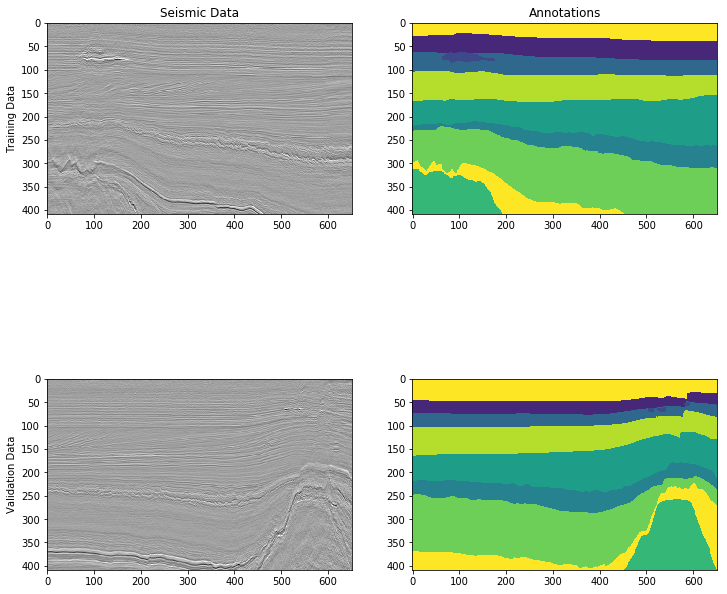

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].imshow(train_images[0], vmin=train_images.min(), vmax=train_images.max(), cmap="gray")
ax[0, 1].imshow(train_annotations[0], vmin=0, vmax=9)

ax[1, 0].imshow(validation_image, vmin=train_images.min(), vmax=train_images.max(), cmap="gray")
ax[1, 1].imshow(validation_annotation, vmin=0, vmax=9)

ax[0, 0].set_ylabel("Training Data")
ax[1, 0].set_ylabel("Validation Data")
ax[0, 0].set_title("Seismic Data")
ax[0, 1].set_title("Annotations")

In [5]:
train_mean, train_std = train_images.mean(), train_images.std()

train_image_normed = (train_images-train_mean)/train_std
validation_image_normed = (validation_image-train_mean)/train_std

Text(0.5, 1.0, 'Annotations')

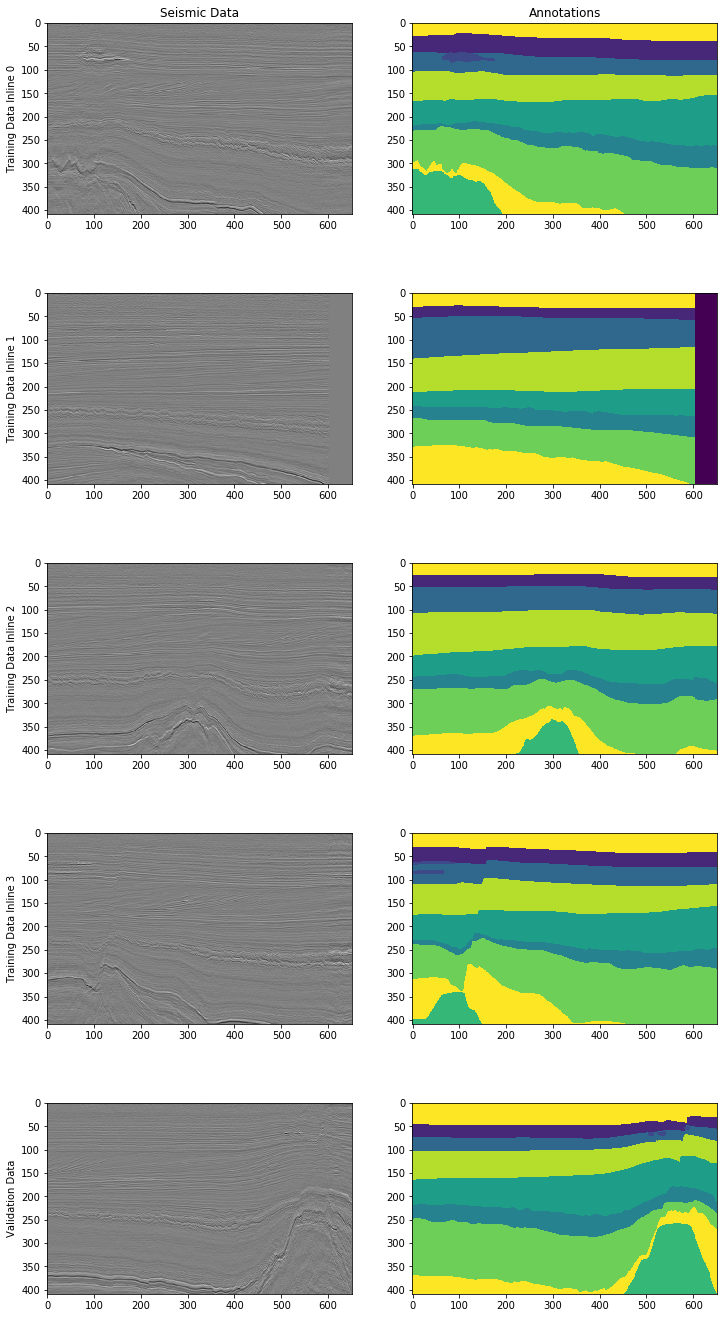

In [9]:
fig, ax = plt.subplots(5, 2, figsize=(12, 24))

for i in range(4):
    ax[i, 0].imshow(train_image_normed[i], vmin=-train_std, vmax=train_std, cmap="gray")
    ax[i, 1].imshow(train_annotations[i], vmin=0, vmax=9)
    ax[i, 0].set_ylabel("Training Data Inline "+str(i))

ax[4, 0].imshow(validation_image_normed, vmin=-train_std, vmax=train_std, cmap="gray")
ax[4, 1].imshow(validation_annotation, vmin=0, vmax=9)

ax[4, 0].set_ylabel("Validation Data")
ax[0, 0].set_title("Seismic Data")
ax[0, 1].set_title("Annotations")

In [10]:
window_half_size = 16

def extract_patches(training_images, inline_annotations, window_half_size=16, increment=4):
    patches = []
    patches_labels = []
    for inline, inline_annotation in zip(training_images, inline_annotations):
        for i in range(window_half_size, inline.shape[0]-window_half_size-1, increment):
            for j in range(window_half_size, inline.shape[1]-window_half_size-1, increment):
                patches.append(inline[i-window_half_size:i+window_half_size+1, j-window_half_size:j+window_half_size+1])
                patches_labels.append(inline_annotation[i, j])
    return np.expand_dims(np.array(patches), -1), np.expand_dims(np.array(patches_labels), -1)

train_patches = extract_patches(train_image_normed, train_annotations)
validation_patches = extract_patches([validation_image_normed], [validation_annotation])

prediction_patches = extract_patches([validation_image_normed], [validation_annotation], increment=1)

print(train_patches[0].shape, validation_patches[0].shape)

(58280, 33, 33, 1) (14570, 33, 33, 1)


In [13]:
batch_size = 128
num_classes = 11
epochs = 50

# input image dimensions
img_rows, img_cols = 33, 33

x_train = train_patches[0]
y_train = train_patches[1]

x_val, y_val = validation_patches

x_pred, y_pred = prediction_patches

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    x_pred = x_pred.reshape(x_pred.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_pred = x_pred.reshape(x_pred.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_pred = x_pred.astype('float32')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_pred = keras.utils.to_categorical(y_pred, num_classes)

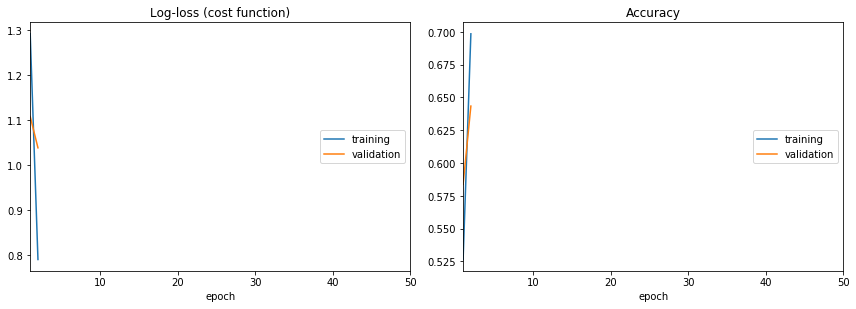

Epoch 3/50
 5888/58280 [==>...........................] - ETA: 3:20 - loss: 0.7307 - acc: 0.7210

KeyboardInterrupt: 

In [14]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

early_cbk = EarlyStopping(monitor='val_acc', mode='max', patience=10, verbose=1)
learning_cbk = ReduceLROnPlateau(monitor='val_acc', mode='max', patience=5, factor=0.1, verbose=1)
checkpointing = ModelCheckpoint('seismic_model.check',
                                save_best_only=True,
                                save_weights_only=True, monitor='val_acc', mode='max')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val), callbacks=[PlotLossesKeras(), early_cbk, learning_cbk, checkpointing])

In [15]:
model.load_weights('seismic_model.check')
score = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
y_pred_model = model.predict(x_pred, verbose=1)

Validation loss: 1.0385740982500264
Validation accuracy: 0.6434454358270418
232368/232368 [==============================] - 264s 1ms/step


In [16]:
height = len(range(window_half_size, validation_annotation.shape[0]-window_half_size-1, 1))
width = len(range(window_half_size, validation_annotation.shape[1]-window_half_size-1, 1))

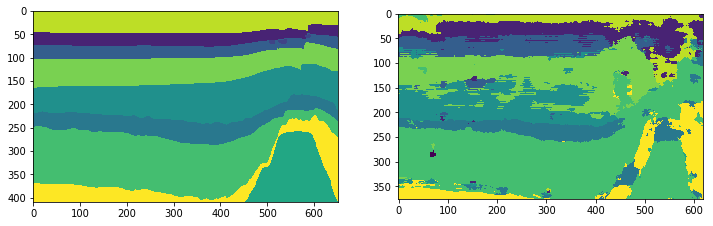

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(validation_annotation, vmin=0, vmax=10)
ax[1].imshow(np.argmax(y_pred_model.reshape(height, width, 11), axis=2), vmin=0, vmax=10)

In [22]:
print(confusion_matrix(y_pred=np.argmax(y_pred_model, 1), y_true=np.argmax(y_pred, 1)))

[[    0     0     0     0     0     0     0     0     0     0     0]
 [    0  9643     0  4591     4     0     0     0    68  1051     0]
 [    0   165    30   101    28     0     0     0     0    12     0]
 [    0  1694    23 10505   144   989     0    15  1756   355     0]
 [    0    65     0    81 11419  2996     4  7223     0     0   742]
 [    0   362     0   516   302 20997     0  7632 12926  1305   186]
 [    0     0     0     0  1460     0   160 11004     0     0  3019]
 [  108    69     0     0  1355   614    10 52325   133    45  3170]
 [    0  2060     0  1270   586  1474     0   625 24200  1705     0]
 [    0  6382     0     0     0     0     0   934     0 11536     0]
 [    0     0     0     0  1587     0     2    41     0     0  8564]]


In [30]:
print("Accuracy: ", accuracy_score(y_pred=np.argmax(y_pred_model, 1), y_true=np.argmax(y_pred, 1)))
print("F1 Score: ", f1_score(y_pred=np.argmax(y_pred_model, 1), y_true=np.argmax(y_pred, 1), average='micro'))

Accuracy:  0.6428552984920471
F1 Score:  0.6428552984920471
